In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.3.3-bin-hadoop2.7')
import pyspark

ModuleNotFoundError: No module named 'findspark'

In [ ]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName('yes').getOrCreate()

In [4]:
dff = spark.read.csv('train.csv', header=True, inferSchema=True)

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql.functions import isnull, when, col, isnan, count
import matplotlib.pyplot as plt
from pyspark.sql.types import *
import datetime
from pyspark.sql.functions import year, month, dayofmonth
# pd.set_option('display.max_rows', 500)

In [5]:
dff.count()

30471

In [10]:
df = dff.sample(False, 0.3)

In [15]:
df.count()

9074

# Data info and Cleaning

In [10]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- full_sq: integer (nullable = true)
 |-- life_sq: string (nullable = true)
 |-- floor: string (nullable = true)
 |-- max_floor: string (nullable = true)
 |-- material: string (nullable = true)
 |-- build_year: string (nullable = true)
 |-- num_room: string (nullable = true)
 |-- kitch_sq: string (nullable = true)
 |-- state: string (nullable = true)
 |-- product_type: string (nullable = true)
 |-- sub_area: string (nullable = true)
 |-- area_m: double (nullable = true)
 |-- raion_popul: integer (nullable = true)
 |-- green_zone_part: double (nullable = true)
 |-- indust_part: double (nullable = true)
 |-- children_preschool: integer (nullable = true)
 |-- preschool_quota: string (nullable = true)
 |-- preschool_education_centers_raion: integer (nullable = true)
 |-- children_school: integer (nullable = true)
 |-- school_quota: string (nullable = true)
 |-- school_education_centers_raion: integer (nu

In [39]:
df.limit(5).toPandas().transpose()

,0,1,2,3,4
id,3,8,9,11,13
timestamp,2011-08-27 00:00:00,2011-09-09 00:00:00,2011-09-10 00:00:00,2011-09-16 00:00:00,2011-09-17 00:00:00
full_sq,43,44,42,36,43
life_sq,29,44,27,19,28
floor,2,5,5,12,4
product_type,Investment,Investment,Investment,Investment,Investment
sub_area,Tekstil'shhiki,Bibirevo,Koptevo,Kosino-Uhtomskoe,Kuncevo
area_m,4.80827e+06,6.40758e+06,4.78742e+06,1.48836e+07,5.23518e+07
raion_popul,101708,155572,96959,72131,142462
green_zone_part,0.11256,0.189727,0.0384559,0.0244442,0.0706621


#### Checking if there are any missing values

In [18]:
df.select([count(when(isnull(c),c)).alias(c) for c in df.columns]).toPandas()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,0,0,1922,53,2883,2883,4108,2883,2883,4105,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df = df.withColumn('month', month(df['timestamp']))
df = df.withColumn('year', year(df['timestamp']))

In [16]:
import pyspark.sql.functions as F
cols = [F.when(~F.col(x).isin('NULL','NA','NaN'),F.col(x)).alias(x) for x in df.columns]

In [17]:
df = df.select(*cols)

In [10]:
df.select([count(when(isnull(c),c)).alias(c) for c in df.columns]).toPandas().transpose()

,0
id,0
full_sq,0
life_sq,1932
floor,49
max_floor,2887
material,2887
build_year,4149
num_room,2887
kitch_sq,2887
state,4079


#### Checking the null values

In [18]:
dfp = df.sample(False, 0.3).toPandas()

In [16]:
len(dfp)

2827

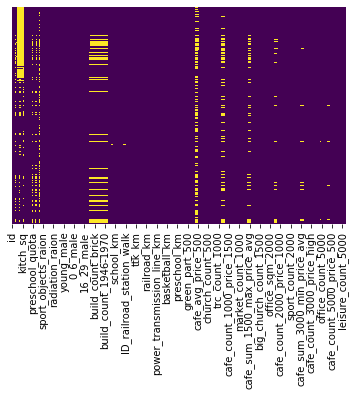

In [17]:
sns.heatmap(dfp.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [19]:
dfp1 = df.select([count(when(isnull(c),c)).alias(c) for c in df.columns]).toPandas()
dfp2 = dfp1.stack()

In [19]:
dfp2[dfp2>2000]

0  life_sq                       2006
   max_floor                     2897
   material                      2897
   build_year                    4114
   num_room                      2897
   kitch_sq                      2897
   state                         4123
   preschool_quota               2024
   school_quota                  2022
   hospital_beds_raion           4379
   cafe_sum_500_min_price_avg    4019
   cafe_sum_500_max_price_avg    4019
   cafe_avg_price_500            4019
dtype: int64

#### There are quite a few missing values from the sampled set, dropping those with more than 80% missing values

In [20]:
removelist = list(dfp2[dfp2>2000][0].index)

In [21]:
df = df.drop('max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'state',
 'preschool_quota',
 'school_quota',
 'hospital_beds_raion',
 'cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500')

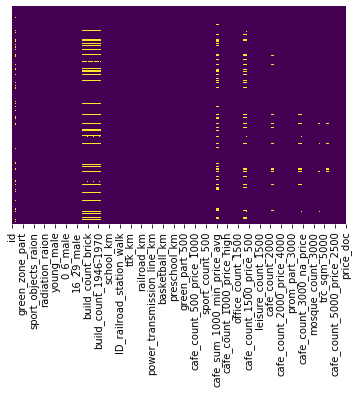

In [22]:
sns.heatmap(df.sample(False,0.2).toPandas().isnull(), yticklabels=False, cbar=False, cmap='viridis')

#### Change the colum types to their proper form, and getting all the string columns first

In [22]:
strlist = []
for l in range(len(df.columns)):
    if isinstance(df.schema.fields[l].dataType, StringType) == True:
        strlist.append(df.schema.names[l])

In [24]:
df.select(strlist).limit(10).toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9
life_sq,19,31,21,33,39,20,20,19,30,42
floor,12,4,3,10,7,4,12,1,10,8
product_type,Investment,Investment,Investment,Investment,Investment,Investment,Investment,Investment,Investment,Investment
sub_area,Kosino-Uhtomskoe,Presnenskoe,Lefortovo,Kosino-Uhtomskoe,Juzhnoe Tushino,Otradnoe,Strogino,Staroe Krjukovo,Caricyno,Kon'kovo
culture_objects_top_25,no,yes,no,no,no,no,no,no,no,no
thermal_power_plant_raion,no,no,no,no,no,no,no,no,no,no
incineration_raion,yes,no,no,yes,no,yes,no,no,no,no
oil_chemistry_raion,no,no,no,no,no,no,no,no,no,no
radiation_raion,yes,yes,yes,yes,no,yes,no,no,yes,yes
railroad_terminal_raion,no,no,no,no,no,no,no,no,no,no


In [25]:
df.select('life_sq').limit(1).collect()[0][0]

'19'

#### Now get the columns with numbers in them

In [23]:
numbli = []
for l in strlist:
    if any(c.isnumeric() for c in df.select(l).limit(1).collect()[0][0]) == True:
        numbli.append(l)
    else:
        pass

#### dflist is the column list that are already numeric

In [24]:
dflist = list(set(df.columns)-set(strlist))

#### strlist1 is the column with categorical values

In [25]:
strlist1 = list(set(strlist) - set(numbli))

#### Now we have 3 lists, [ strlist1, numbli, dflist ], convert numbli to float type and append both strlist1 and numbli to dflist

In [26]:
dfli = df.select(*dflist)

In [27]:
dfst = df.select(*strlist1)

In [28]:
dfnu = df.select(*numbli)

In [44]:
dfnu.printSchema()

root
 |-- life_sq: string (nullable = true)
 |-- floor: string (nullable = true)
 |-- raion_build_count_with_material_info: string (nullable = true)
 |-- build_count_block: string (nullable = true)
 |-- build_count_wood: string (nullable = true)
 |-- build_count_frame: string (nullable = true)
 |-- build_count_brick: string (nullable = true)
 |-- build_count_monolith: string (nullable = true)
 |-- build_count_panel: string (nullable = true)
 |-- build_count_foam: string (nullable = true)
 |-- build_count_slag: string (nullable = true)
 |-- build_count_mix: string (nullable = true)
 |-- raion_build_count_with_builddate_info: string (nullable = true)
 |-- build_count_before_1920: string (nullable = true)
 |-- build_count_1921-1945: string (nullable = true)
 |-- build_count_1946-1970: string (nullable = true)
 |-- build_count_1971-1995: string (nullable = true)
 |-- build_count_after_1995: string (nullable = true)
 |-- metro_min_walk: string (nullable = true)
 |-- metro_km_walk: string (n

In [47]:
dfnu.limit(5).toPandas().transpose()

,0,1,2,3,4
life_sq,19,31,21,33,39
floor,12,4,3,10,7
raion_build_count_with_material_info,1204,836,285,1204,332
build_count_block,12,99,68,12,58
build_count_wood,793,6,0,793,0
build_count_frame,36,1,1,36,0
build_count_brick,179,664,159,179,184
build_count_monolith,14,33,0,14,6
build_count_panel,97,30,55,97,84
build_count_foam,0,0,0,0,0


In [29]:
for l in numbli:
    dfnu = dfnu.withColumn(l +'_int', dfnu[l].cast(FloatType()))

dfnu = dfnu.drop(*numbli)

Adding index

In [30]:
from pyspark.sql.functions import monotonically_increasing_id 

In [31]:
dfli = dfli.withColumn("id",monotonically_increasing_id())
dfnu = dfnu.withColumn("id",monotonically_increasing_id())
dfst = dfst.withColumn("id",monotonically_increasing_id())

In [32]:
df2 = dfli.join(dfnu,'id', 'inner')
df2= df2.join(dfst, 'id','inner')
df2 = df2.drop('id')

In [82]:
df2.printSchema()

root
 |-- full_sq: integer (nullable = true)
 |-- swim_pool_km: double (nullable = true)
 |-- sport_count_5000: integer (nullable = true)
 |-- big_church_count_5000: integer (nullable = true)
 |-- office_sqm_1500: integer (nullable = true)
 |-- sport_count_1500: integer (nullable = true)
 |-- indust_part: double (nullable = true)
 |-- sport_count_3000: integer (nullable = true)
 |-- school_km: double (nullable = true)
 |-- cafe_count_3000_price_1000: integer (nullable = true)
 |-- cafe_count_5000_na_price: integer (nullable = true)
 |-- cafe_count_500_price_500: integer (nullable = true)
 |-- prom_part_1500: double (nullable = true)
 |-- cafe_count_2000_price_1500: integer (nullable = true)
 |-- green_part_1000: double (nullable = true)
 |-- ID_big_road2: integer (nullable = true)
 |-- trc_sqm_5000: integer (nullable = true)
 |-- 7_14_male: integer (nullable = true)
 |-- cafe_count_1500_price_2500: integer (nullable = true)
 |-- work_male: integer (nullable = true)
 |-- work_all: integ

In [83]:
df2.limit(5).toPandas().transpose()

,0,1,2,3,4
full_sq,36,31,31,59,39
swim_pool_km,3.75782,0.643302,0.667945,4.1139,2.50588
sport_count_5000,17,166,132,17,64
big_church_count_5000,5,57,63,6,12
office_sqm_1500,0,2556342,214787,0,9881
sport_count_1500,1,12,10,1,9
indust_part,0.158249,0.0420316,0.306977,0.158249,0.188784
sport_count_3000,4,47,45,2,31
school_km,0.317739,0.718828,0.797255,0.678491,0.479055
cafe_count_3000_price_1000,2,92,35,2,27


#### Done transforming DF

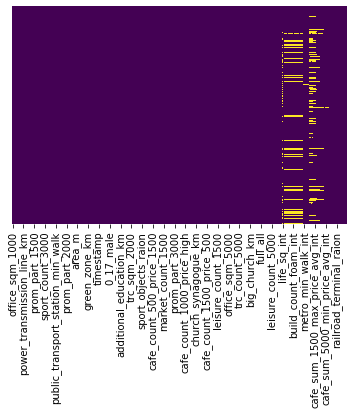

In [25]:
sns.heatmap(df2.sample(False,0.3).toPandas().isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [33]:
li2 = df2.select([count(when(isnull(c),c)).alias(c) for c in df2.columns]).toPandas()

In [34]:
li3 = li2.stack()

In [40]:
li3[li3 > 0 ][0]

life_sq_int                                  1933
floor_int                                      48
raion_build_count_with_material_info_int     1504
build_count_block_int                        1504
build_count_wood_int                         1504
build_count_frame_int                        1504
build_count_brick_int                        1504
build_count_monolith_int                     1504
build_count_panel_int                        1504
build_count_foam_int                         1504
build_count_slag_int                         1504
build_count_mix_int                          1504
raion_build_count_with_builddate_info_int    1504
build_count_before_1920_int                  1504
build_count_1921-1945_int                    1504
build_count_1946-1970_int                    1504
build_count_1971-1995_int                    1504
build_count_after_1995_int                   1504
metro_min_walk_int                              5
metro_km_walk_int                               5


In [35]:
li4 = list(li3[li3 > 0 ][0].index)

#### Filling missing data with median value using imputer

In [36]:
from pyspark.ml.feature import Imputer

In [37]:
li5 = []
for l in li4:
    li5.append(l+'_11')

In [38]:
imputer = Imputer(inputCols=li4, outputCols=li5)

In [39]:
df3 = imputer.setStrategy('median').setMissingValue(1.0).fit(df2).transform(df2)

In [40]:
df3 = df3.drop(*li4)

In [33]:
df3.select([count(when(isnull(c),c)).alias(c) for c in df3.columns]).toPandas().transpose()

,0
green_zone_part,0
7_14_all,0
0_6_male,0
green_zone_km,0
big_church_count_3000,0
cafe_count_1500_price_4000,0
timestamp,0
office_raion,0
leisure_count_1500,0
cafe_count_5000_price_500,0


#### Cleaning done, can began analysing data

# Initial Data analysis with pairplot 

In [41]:
dffspk = df3.sample(0.3, False)
dff = dffspk.toPandas()

In [42]:
dfflist = list(dff.columns)

In [47]:
pd.set_option('max_rows', 300)
dff.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
green_zone_part,2745.0,2.179184e-01,1.719692e-01,1.879375e-03,6.540883e-02,1.675257e-01,3.381510e-01,8.529228e-01
7_14_all,2745.0,5.371208e+03,3.947903e+03,1.680000e+02,1.564000e+03,5.285000e+03,7.538000e+03,1.908300e+04
0_6_male,2745.0,2.640607e+03,1.953381e+03,9.100000e+01,8.620000e+02,2.565000e+03,3.589000e+03,9.987000e+03
green_zone_km,2745.0,3.020204e-01,3.006727e-01,0.000000e+00,1.029811e-01,2.143362e-01,4.098556e-01,1.982448e+00
big_church_count_3000,2745.0,5.932969e+00,1.516358e+01,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00,9.400000e+01
cafe_count_1500_price_4000,2745.0,1.427687e+00,6.819836e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.200000e+01
office_raion,2745.0,7.881239e+00,2.313833e+01,0.000000e+00,0.000000e+00,2.000000e+00,5.000000e+00,1.410000e+02
leisure_count_1500,2745.0,8.848816e-01,3.266895e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01
cafe_count_5000_price_500,2745.0,6.342550e+01,1.218467e+02,0.000000e+00,5.000000e+00,2.700000e+01,5.500000e+01,6.390000e+02
cafe_count_5000_price_1000,2745.0,7.073333e+01,1.222589e+02,0.000000e+00,8.000000e+00,3.600000e+01,6.600000e+01,6.420000e+02


## Distribution of log scale prices

In [59]:
price = dff['price_doc']

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


(array([2.09612016e-09, 1.57209012e-08, 7.96525661e-08, 7.33642057e-09,
        6.18355448e-08, 1.88650815e-08, 2.09612016e-08, 6.49797250e-08,
        5.34510641e-08, 5.86913645e-08, 1.02709888e-07, 1.02709888e-07,
        1.44632291e-07, 1.57209012e-07, 1.70833793e-07, 1.78170214e-07,
        1.89698875e-07, 1.99131415e-07, 1.37295871e-07, 1.04806008e-07,
        1.12142429e-07, 1.02709888e-07, 8.59409266e-08, 8.17486863e-08,
        6.70758452e-08, 5.34510641e-08, 4.71627036e-08, 3.14418024e-08,
        2.51534419e-08, 3.66821028e-08, 2.93456823e-08, 1.99131415e-08,
        2.30573218e-08, 2.93456823e-08, 2.41053819e-08, 1.99131415e-08,
        1.67689613e-08, 2.20092617e-08, 1.04806008e-08, 1.67689613e-08,
        1.25767210e-08, 1.25767210e-08, 1.46728411e-08, 1.25767210e-08,
        9.43254073e-09, 6.28836048e-09, 9.43254073e-09, 3.14418024e-09,
        2.09612016e-09, 7.33642057e-09, 8.38448065e-09, 1.04806008e-09,
        4.19224032e-09, 1.04806008e-09, 1.04806008e-09, 2.096120

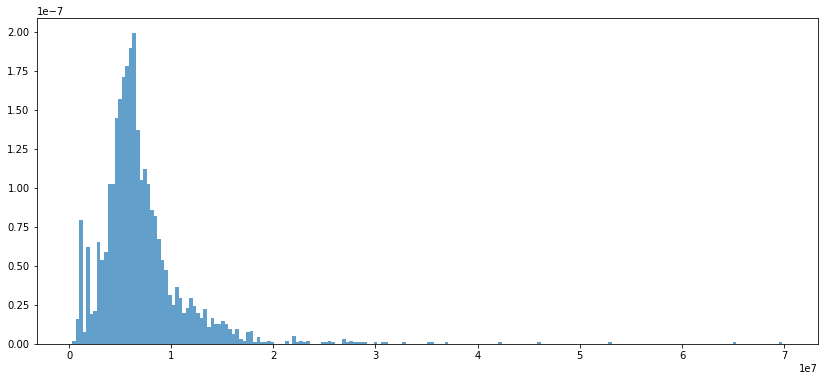

In [61]:
plt.figure(figsize=(14,6))
plt.hist(dff['price_doc'], bins=200, normed=True, alpha=0.7)

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


(array([0.01336907, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.01336907, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.20053603, 0.82888227,
        0.01336907, 0.        , 0.08021441, 0.01336907, 0.        ,
        0.05347628, 0.01336907, 0.        , 0.01336907, 0.        ,
        0.01336907, 0.02673814, 0.        , 0.        , 0.05347628,
        0.        , 0.        , 0.        , 0.02673814, 0.01336907,
        0.01336907, 0.        , 0.01336907, 0.01336907, 0.70856065,
        0.02673814, 0.04010721, 0.01336907, 0.06

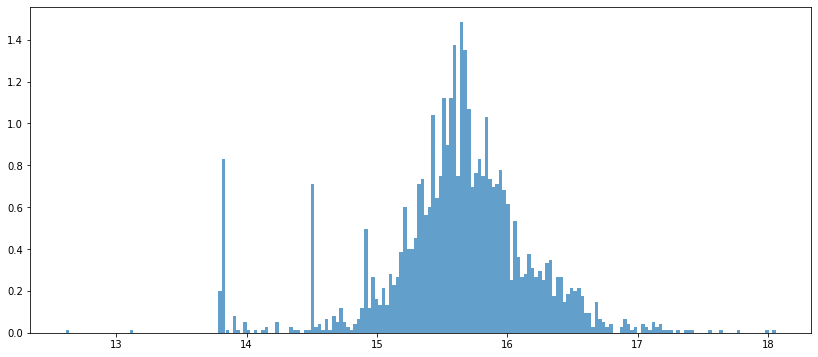

In [62]:
plt.figure(figsize=(14,6))
plt.hist(np.log(price), bins=200, normed=True, alpha=0.7)

## Filter by km
Getting list that contains km

In [118]:
kmlist = list(filter(lambda k: 'km' in k.lower(), dfflist))

In [119]:
kmlist.append('price_doc')

In [121]:
dfkm = dff[kmlist]

#### Correlation heatmap

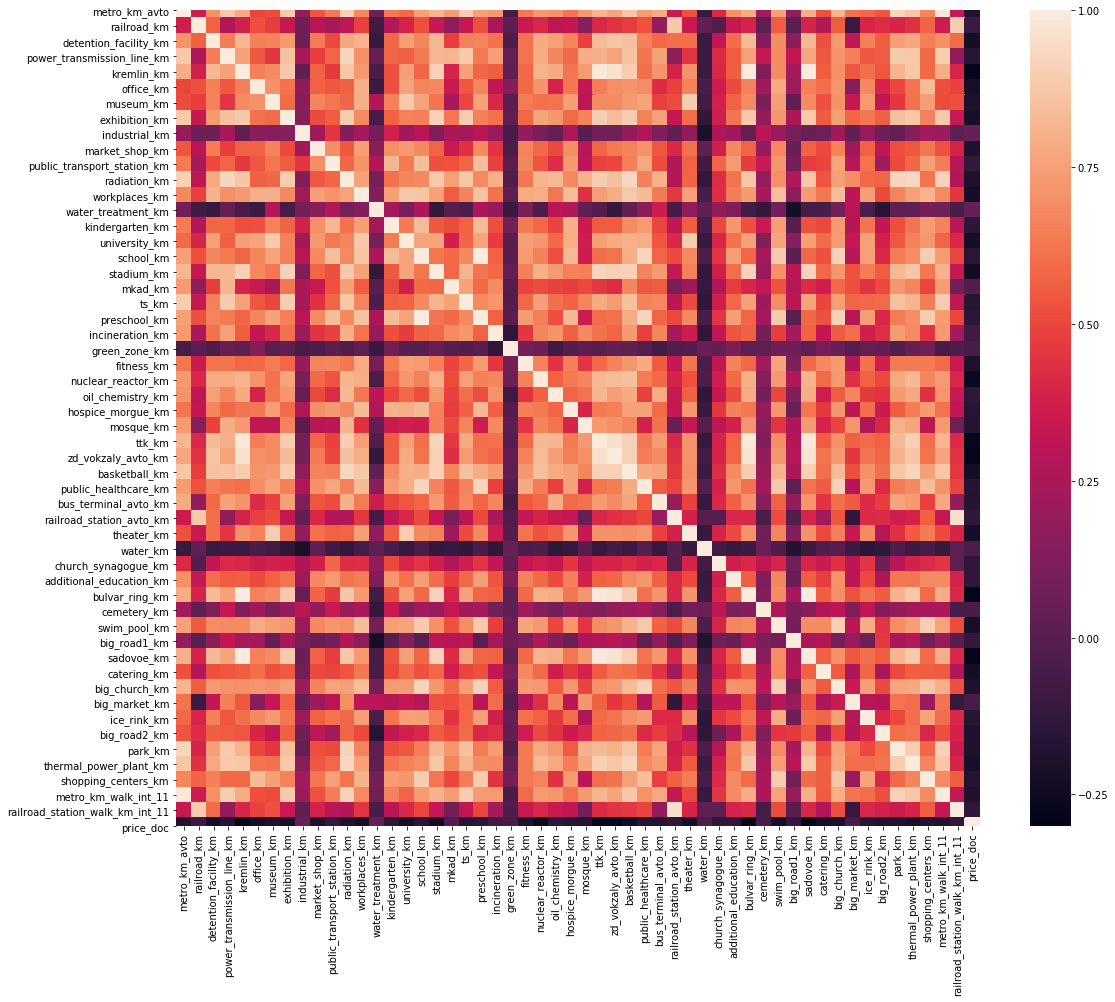

In [124]:
plt.figure(figsize=(18,15))
sns.heatmap(dfkm.corr())

In [135]:
pk = dfkm.corr()['price_doc']
pk[pk > -0.1]

railroad_km          -0.097036
industrial_km         0.049265
water_treatment_km    0.047959
mkad_km              -0.020326
incineration_km      -0.074371
green_zone_km        -0.061027
water_km             -0.042611
cemetery_km          -0.051958
big_market_km        -0.060098
price_doc             1.000000
Name: price_doc, dtype: float64

In [136]:
pk[pk < -0.1]

metro_km_avto                     -0.185171
detention_facility_km             -0.231534
power_transmission_line_km        -0.161408
kremlin_km                        -0.291035
office_km                         -0.227115
museum_km                         -0.200429
exhibition_km                     -0.213940
market_shop_km                    -0.192713
public_transport_station_km       -0.118424
radiation_km                      -0.202984
workplaces_km                     -0.226334
kindergarten_km                   -0.144336
university_km                     -0.227824
school_km                         -0.148871
stadium_km                        -0.241431
ts_km                             -0.166534
preschool_km                      -0.147042
fitness_km                        -0.198551
nuclear_reactor_km                -0.262271
oil_chemistry_km                  -0.137366
hospice_morgue_km                 -0.162495
mosque_km                         -0.170409
ttk_km                          

In [140]:
pk1 = list(pk[pk > -0.1].index)

#### correlation pair plots with km features and price

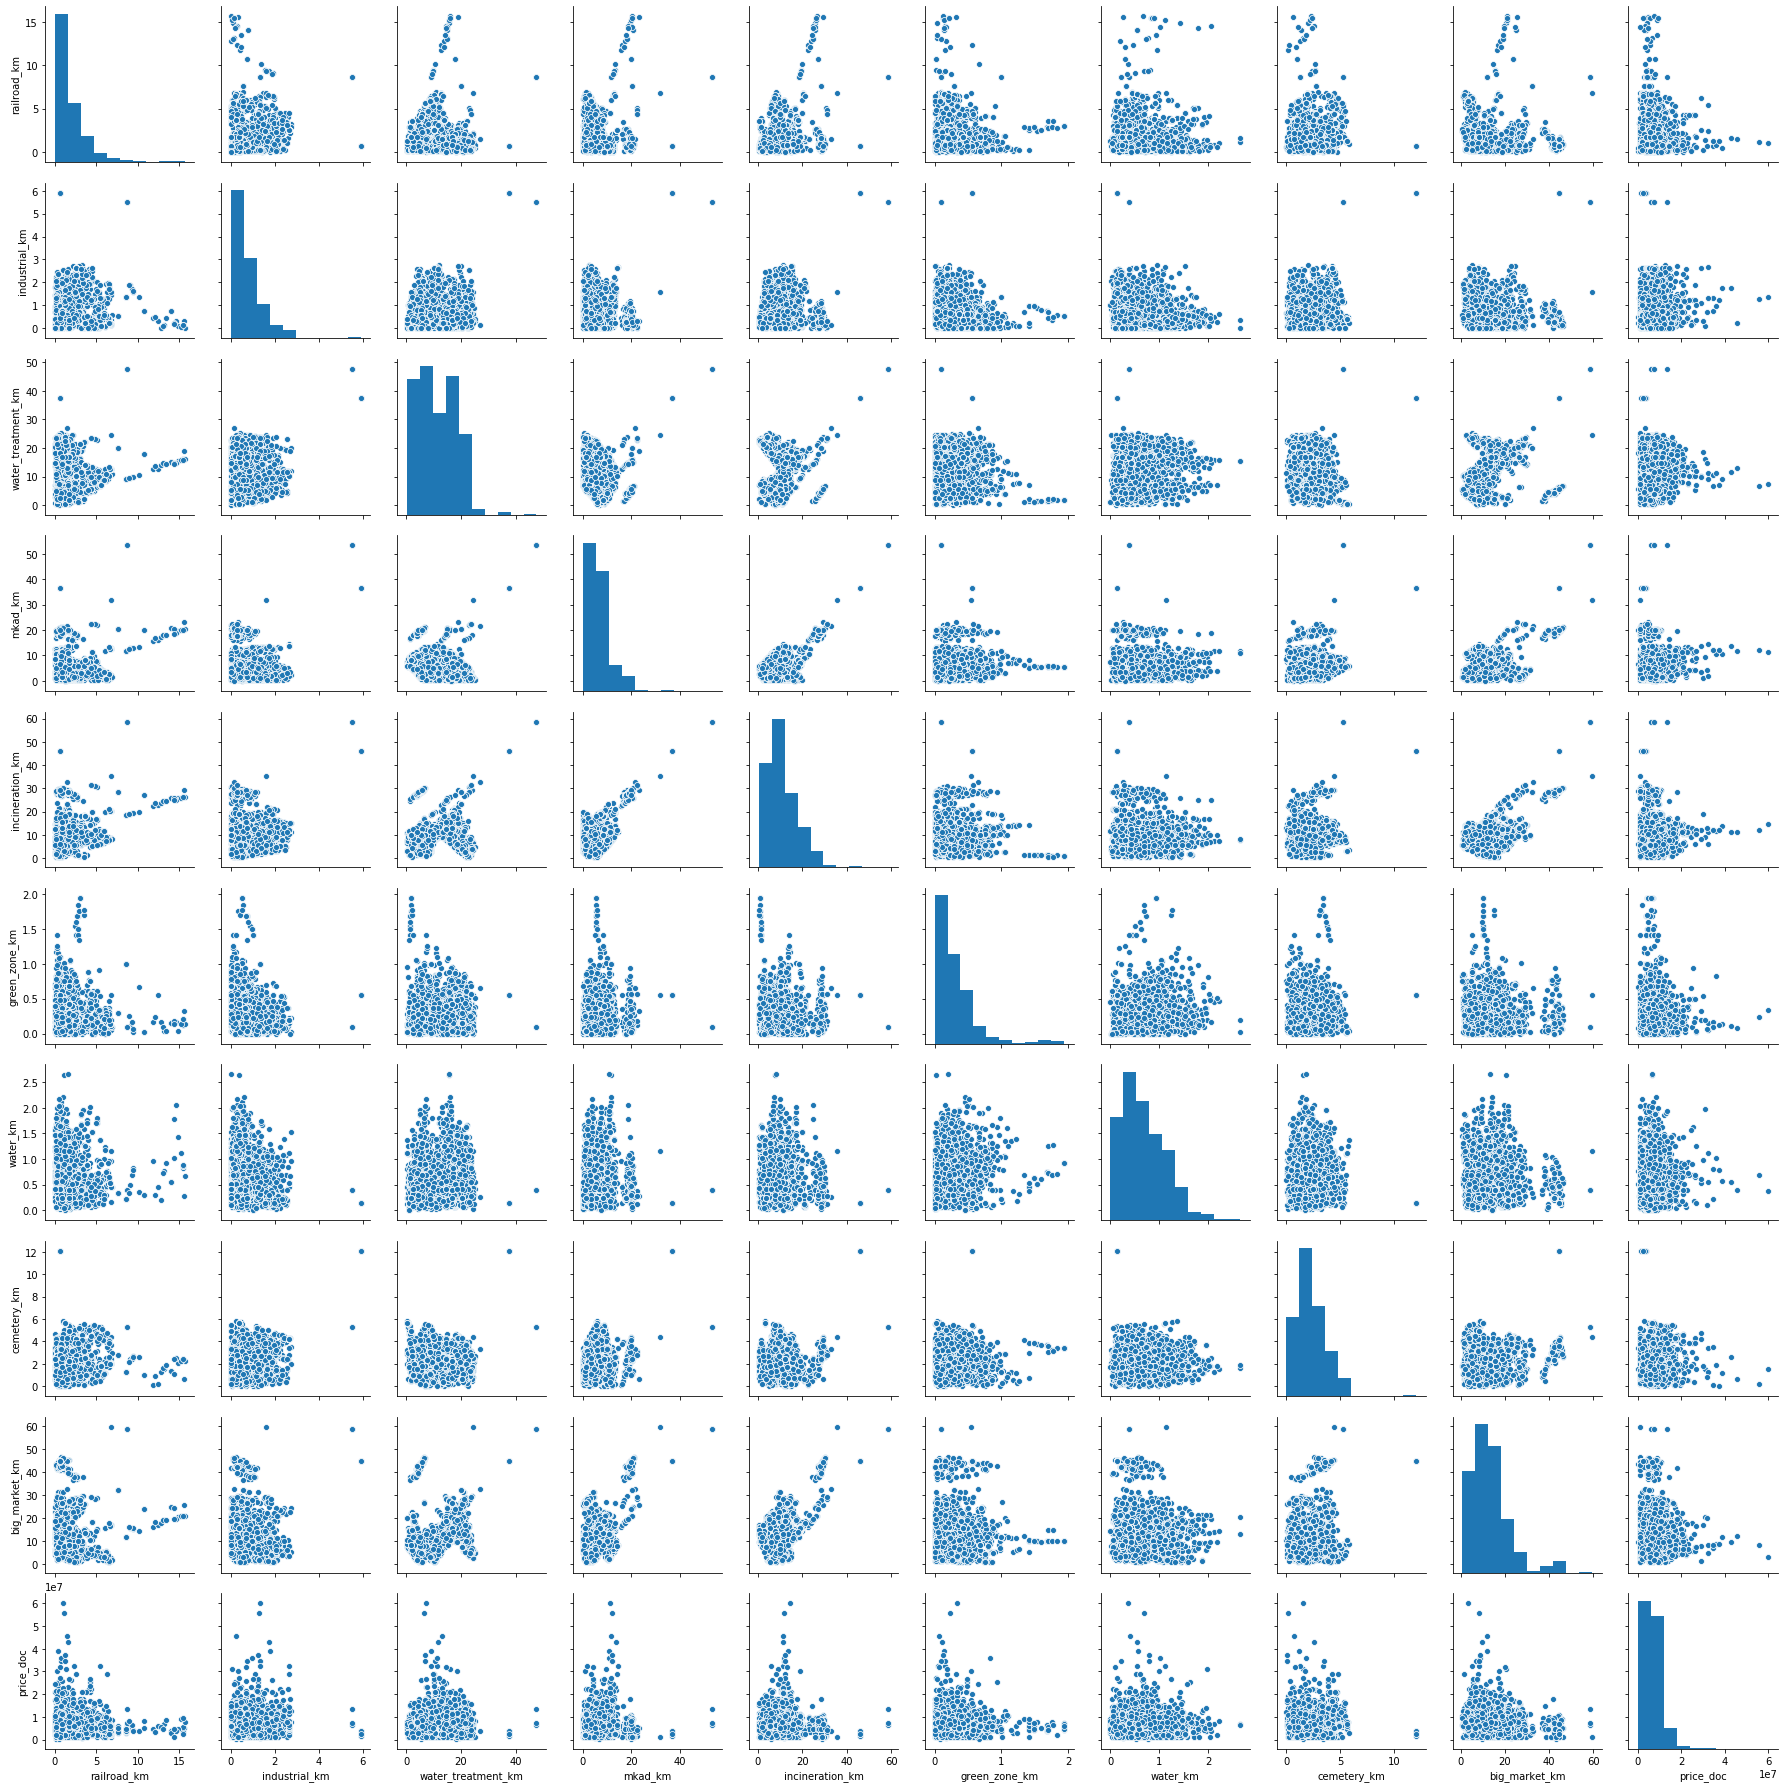

In [144]:
sns.pairplot(dff[pk1])

There are definately correlations between the different features not just from price_doc but to each other as well

## Filter by sqm

In [35]:
sqmlist = list(filter(lambda k: 'sqm' in k.lower(), dfflist))

In [36]:
sqmlist.append('price_doc')

In [37]:
dfsqm = dff[sqmlist]

#### Correlation heatmap

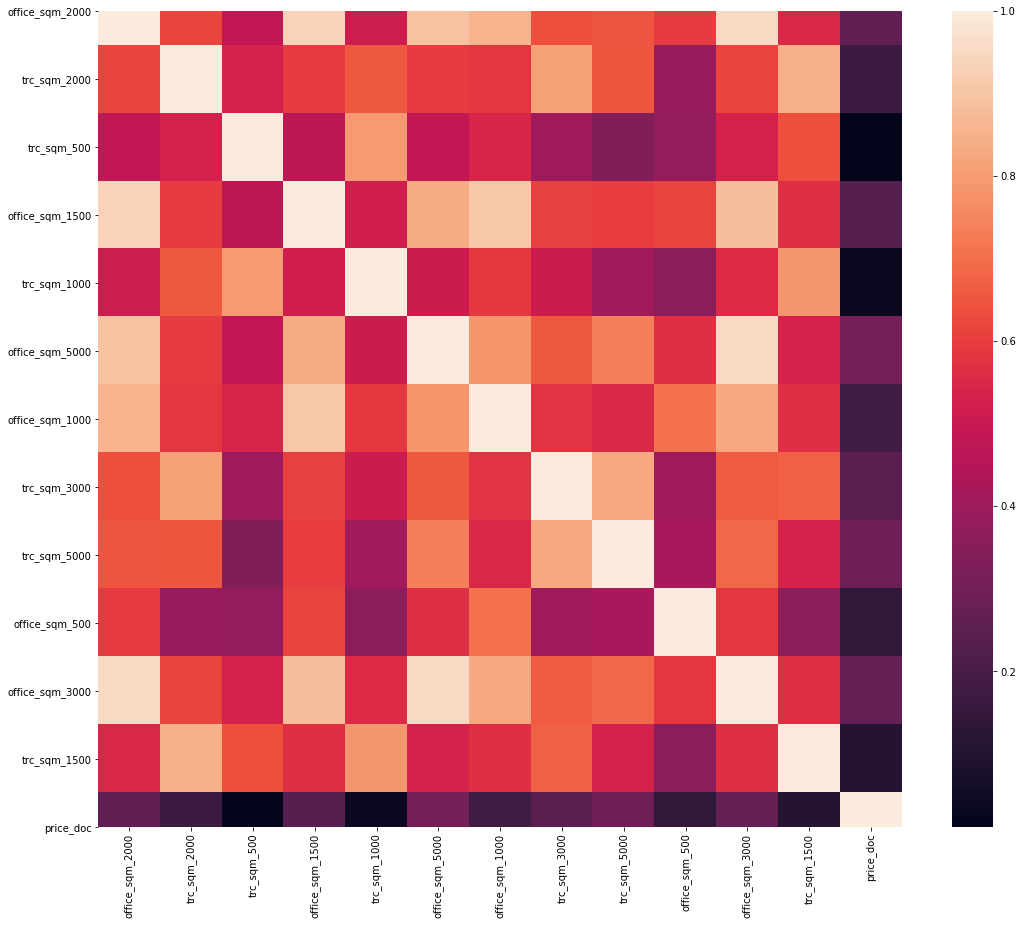

In [149]:
plt.figure(figsize=(18,15))
sns.heatmap(dfsqm.corr())

In [153]:
pksqm = dfsqm.corr()['price_doc']
pksqm[pksqm > 0.2]

office_sqm_2000    0.259390
office_sqm_1500    0.231570
office_sqm_5000    0.308706
trc_sqm_3000       0.250784
trc_sqm_5000       0.292527
office_sqm_3000    0.267696
price_doc          1.000000
Name: price_doc, dtype: float64

In [154]:
pksqm[pksqm < 0.2]

trc_sqm_2000       0.169807
trc_sqm_500        0.012149
trc_sqm_1000       0.042751
office_sqm_1000    0.179496
office_sqm_500     0.140964
trc_sqm_1500       0.107116
Name: price_doc, dtype: float64

#### Pairplot for sqm features and price

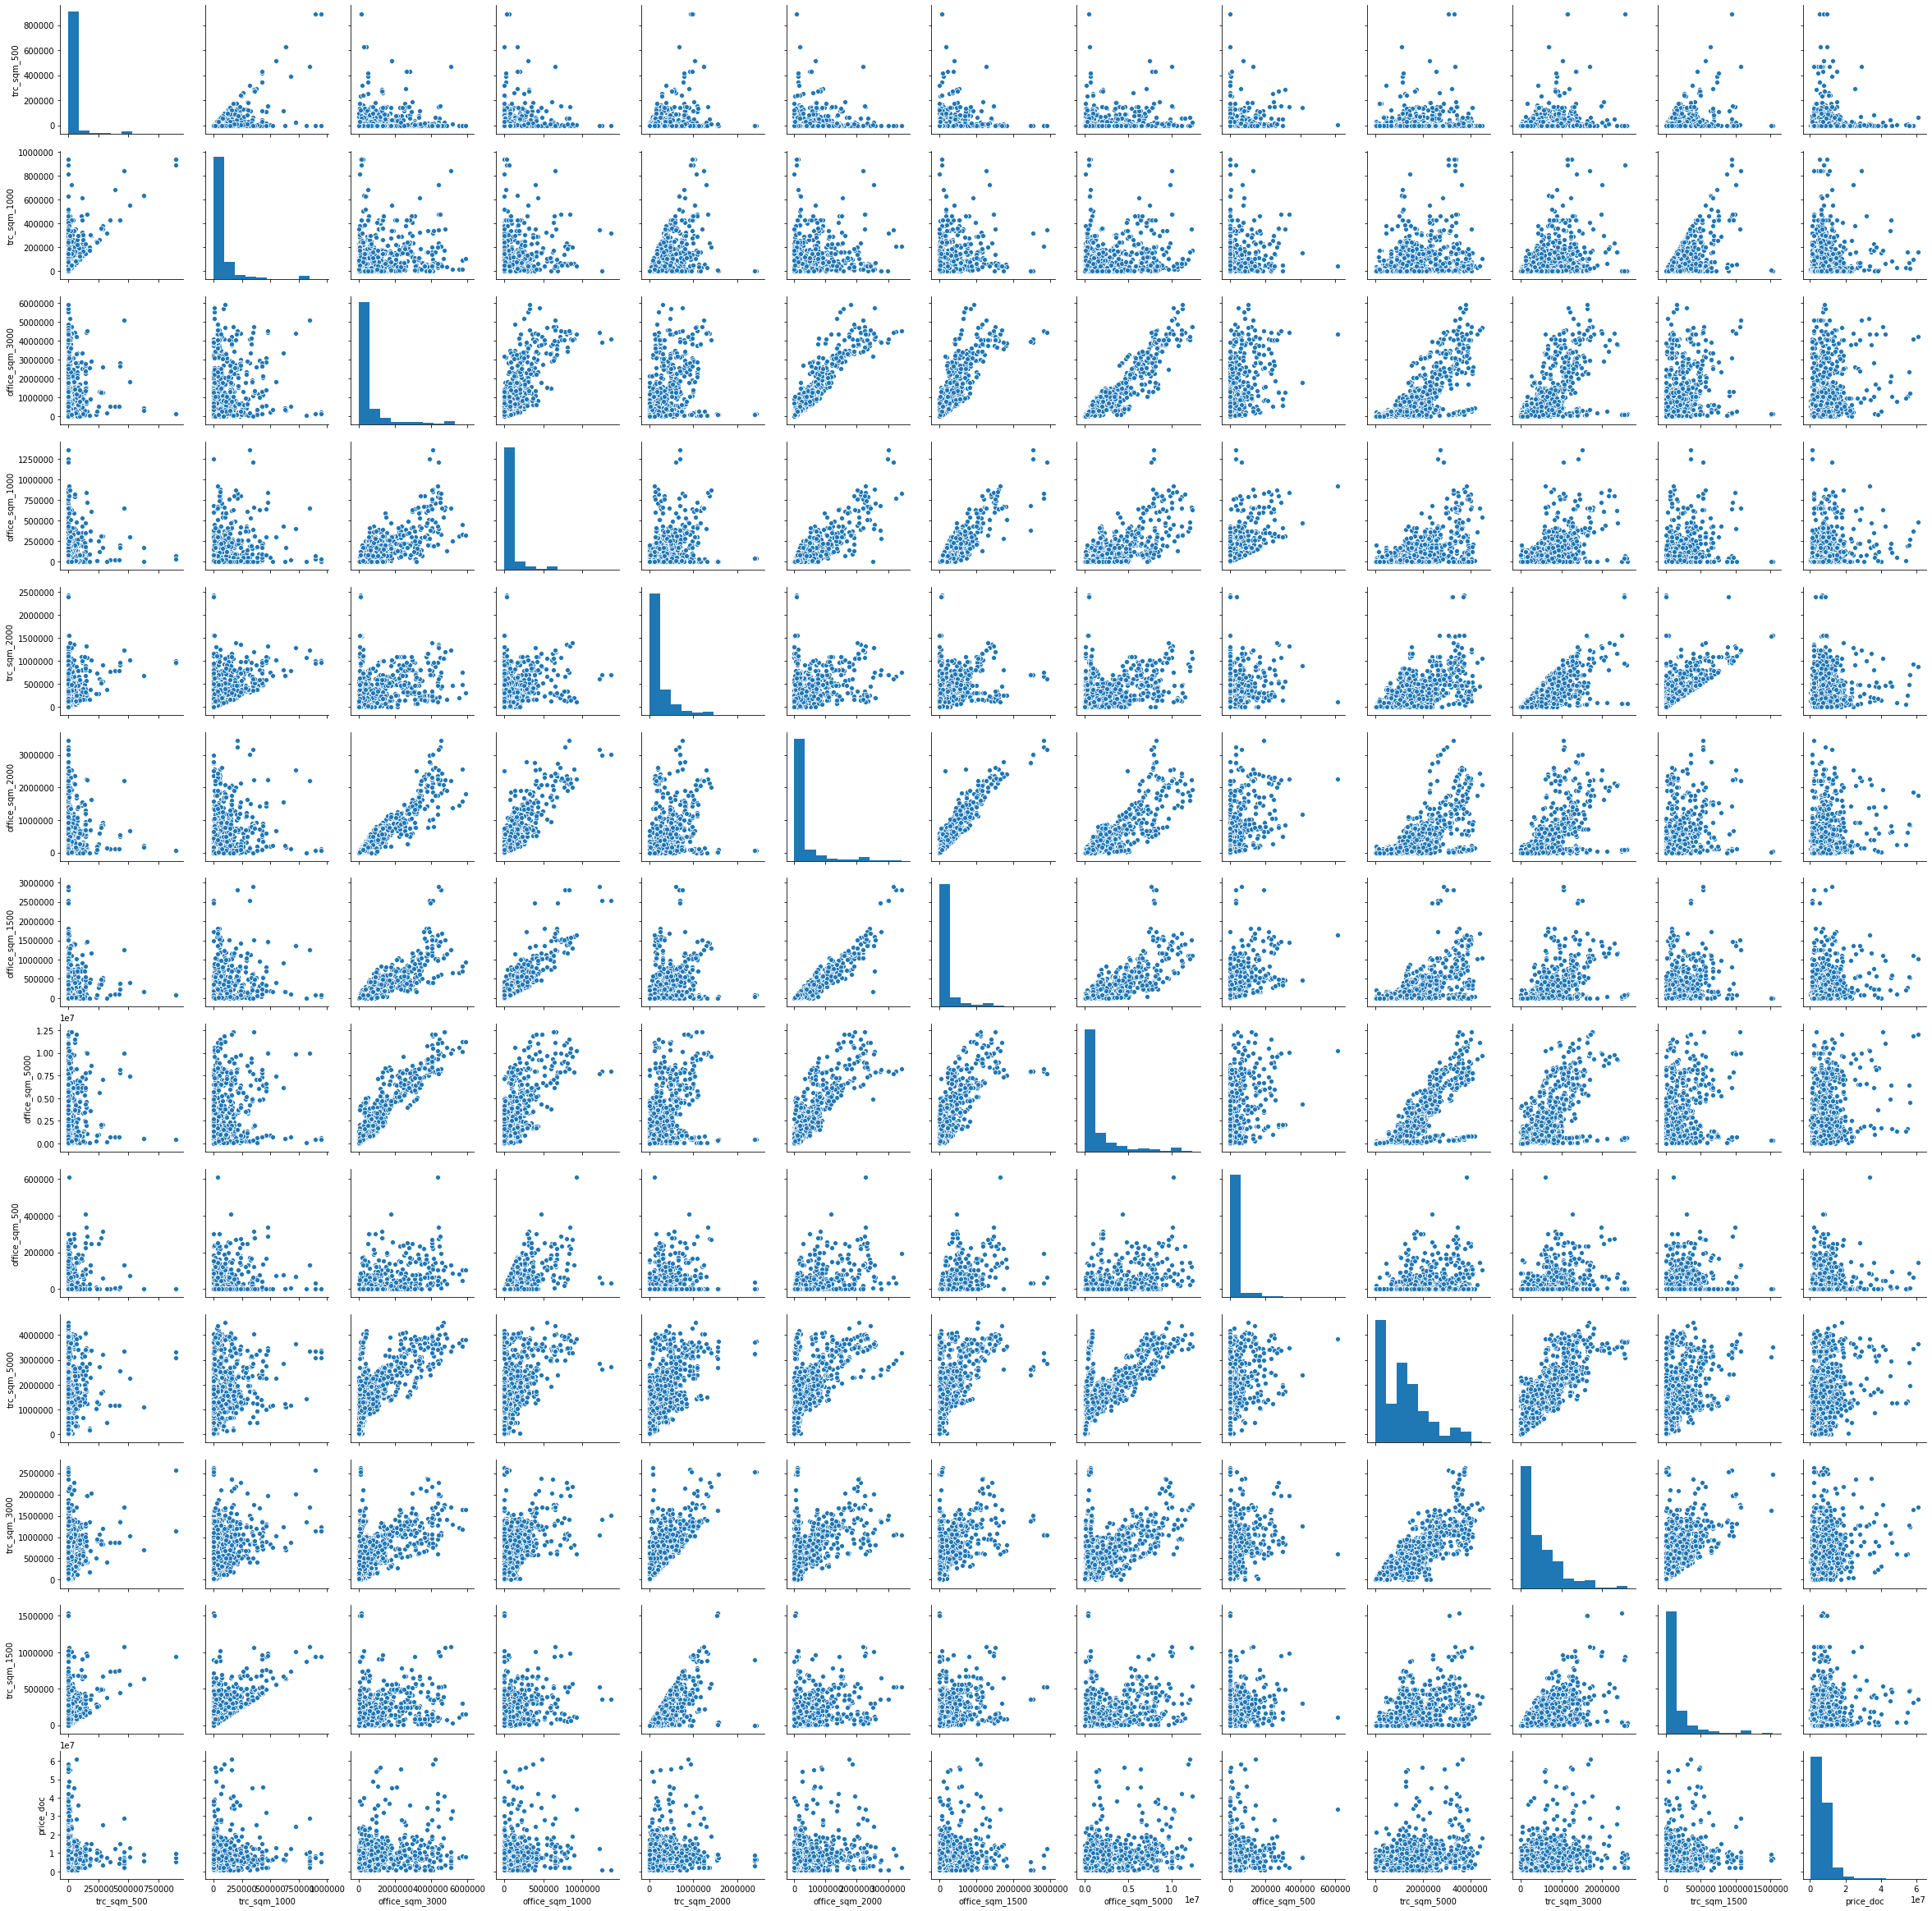

In [38]:
sns.pairplot(dfsqm)

Again there are correlations in the features espeically with trc_sqm. However the relationship to price isnt that obvious and would require further investigation.

## Filter by build

In [35]:
buildlist = list(filter(lambda k: 'build' in k.lower(), dfflist))

In [36]:
buildlist.append('price_doc')

In [37]:
dfbuild = dff[buildlist]

#### Heatmap of build features

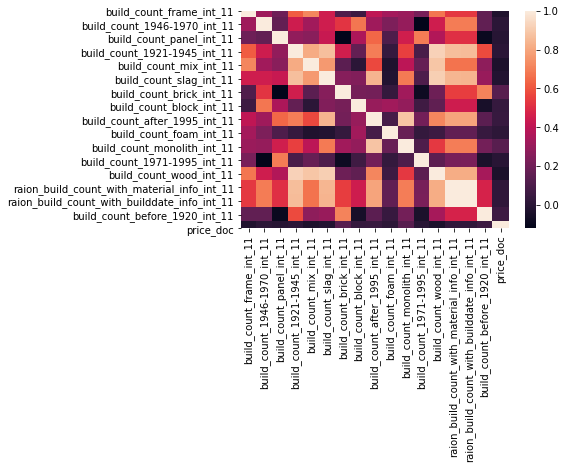

In [44]:
sns.heatmap(dfbuild.corr())

In [38]:
pkbuild = dfbuild.corr()['price_doc']

In [49]:
pkbu = list(pkbuild[pkbuild >0.02].index)

In [50]:
pkbu.append('price_doc')

#### Pairplot with build features, the 2nd pairplot is with correlations that is above 0.02 overall

AttributeError: 'PairGrid' object has no attribute 'set_xticklabels'

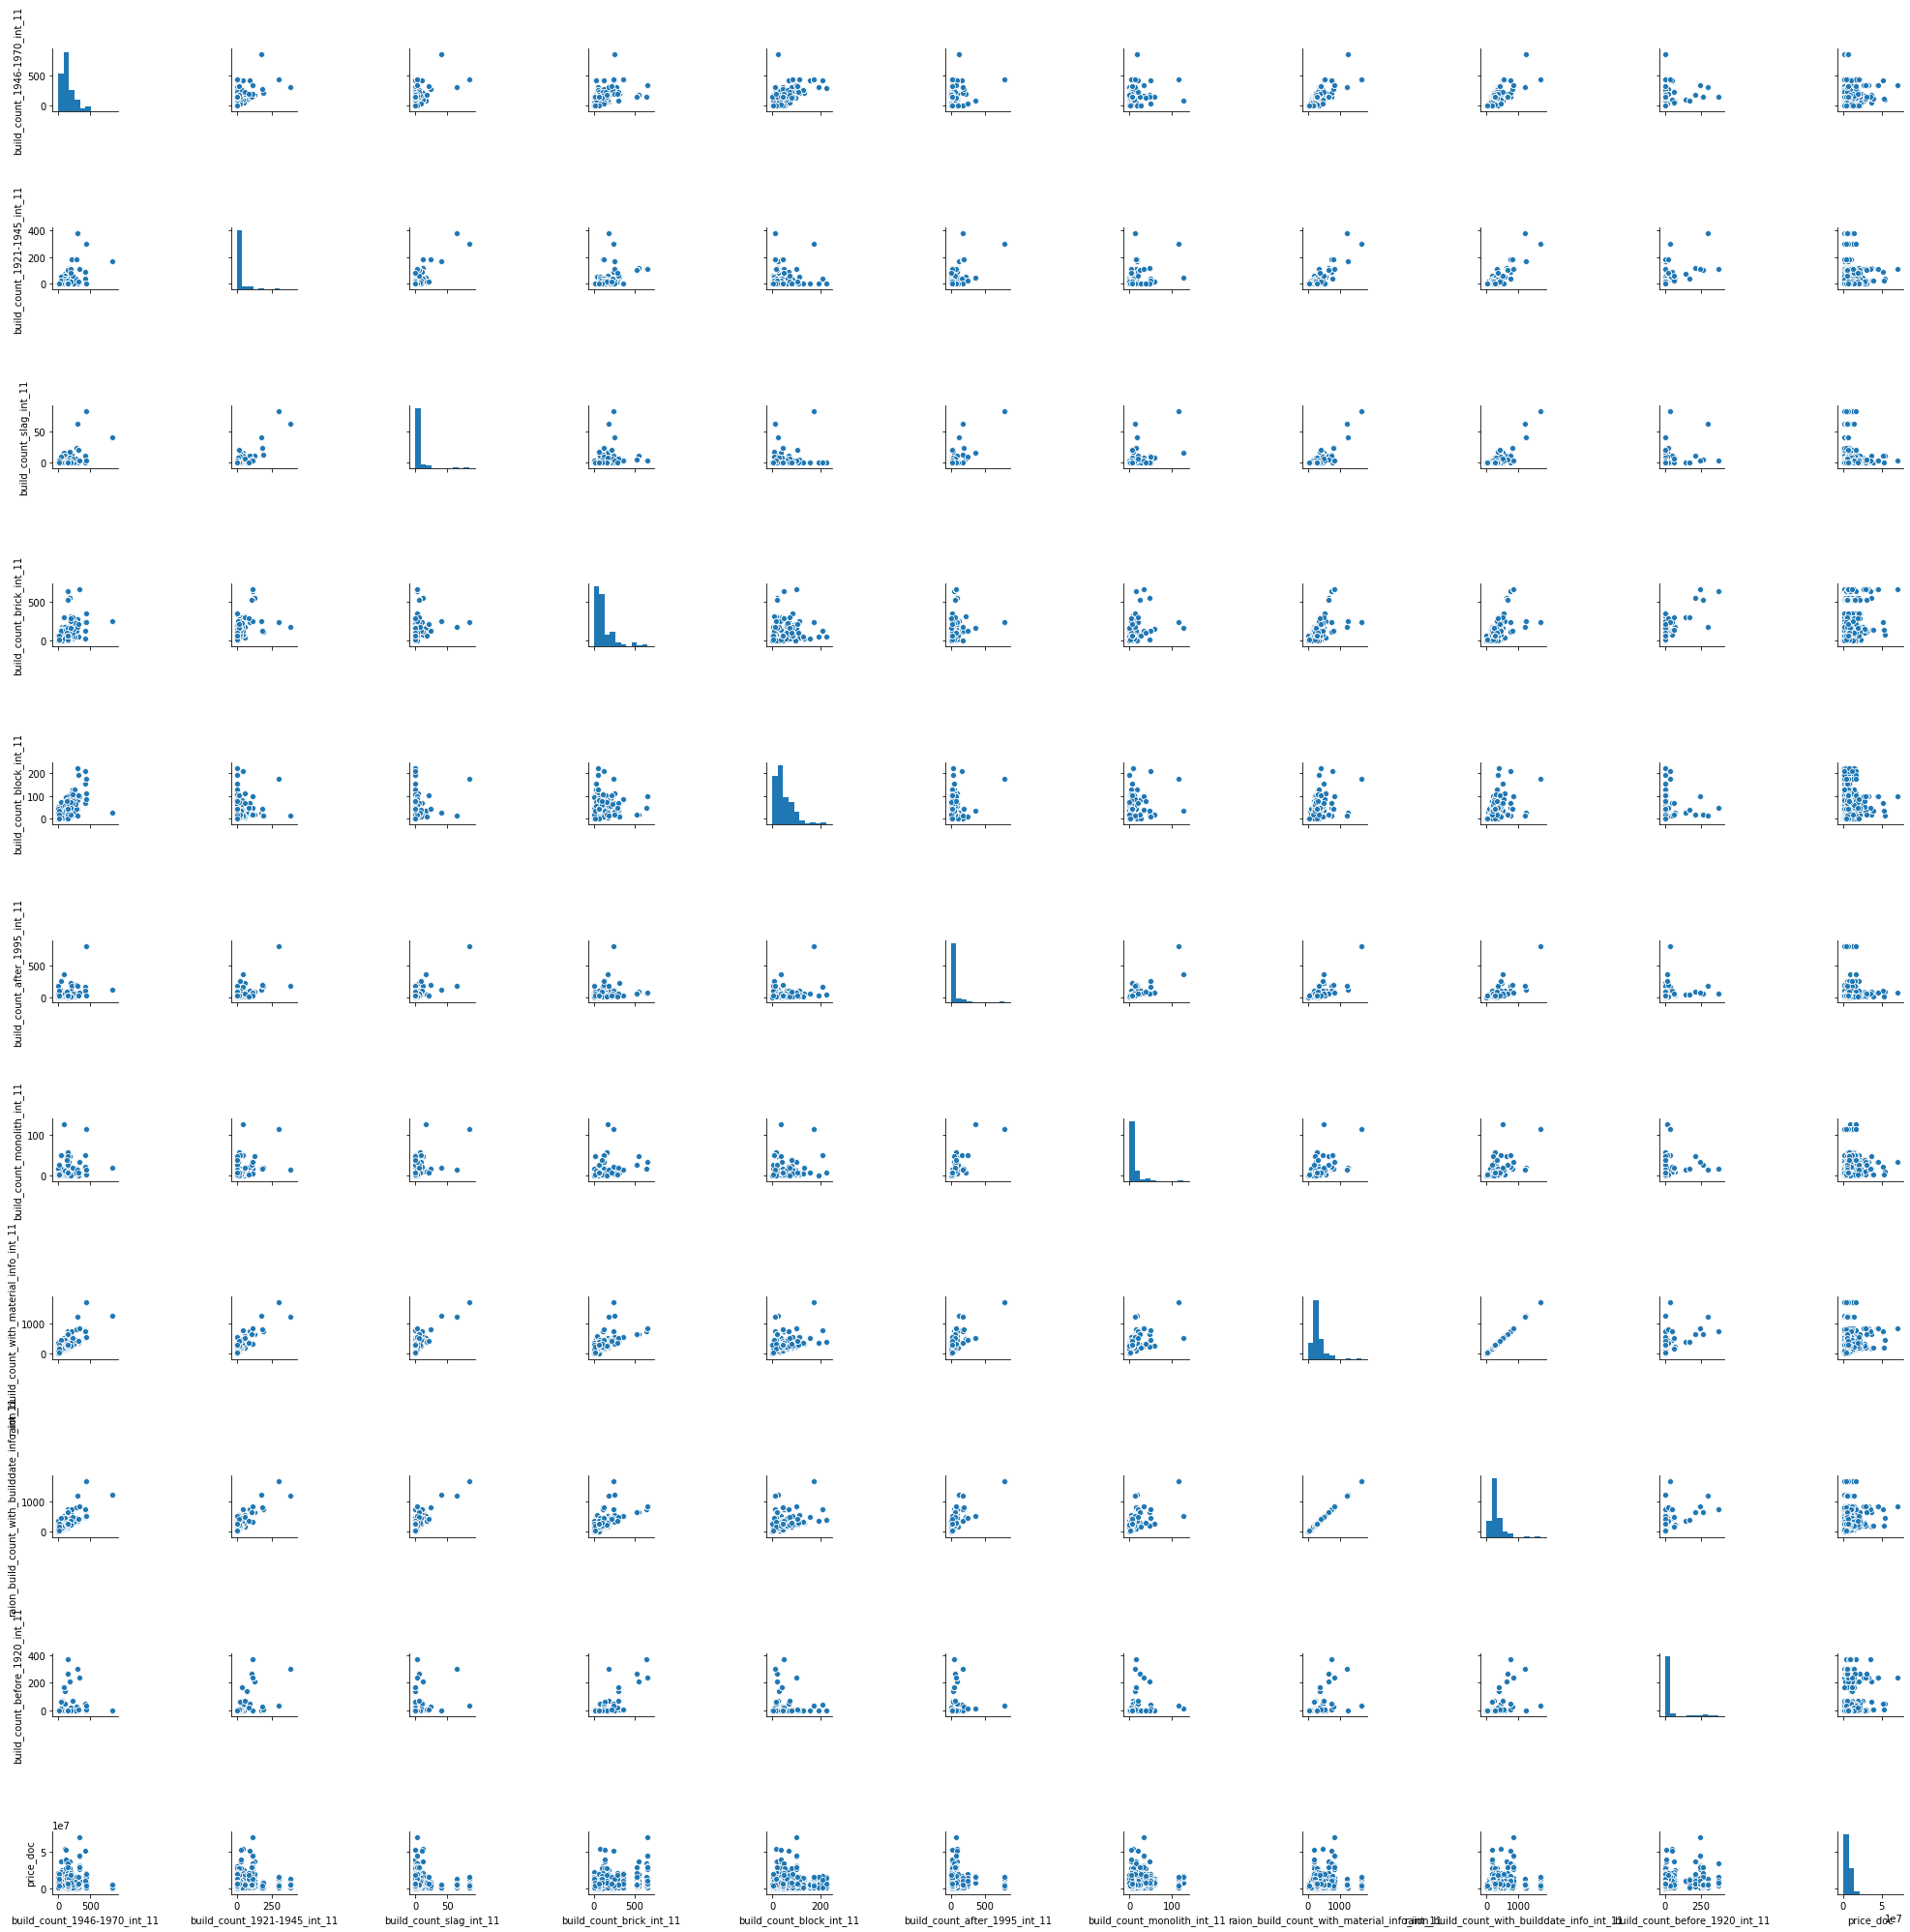

In [41]:
g = sns.pairplot(dfbuild[pkbu])
g.set_xticklabels(rotation=45)

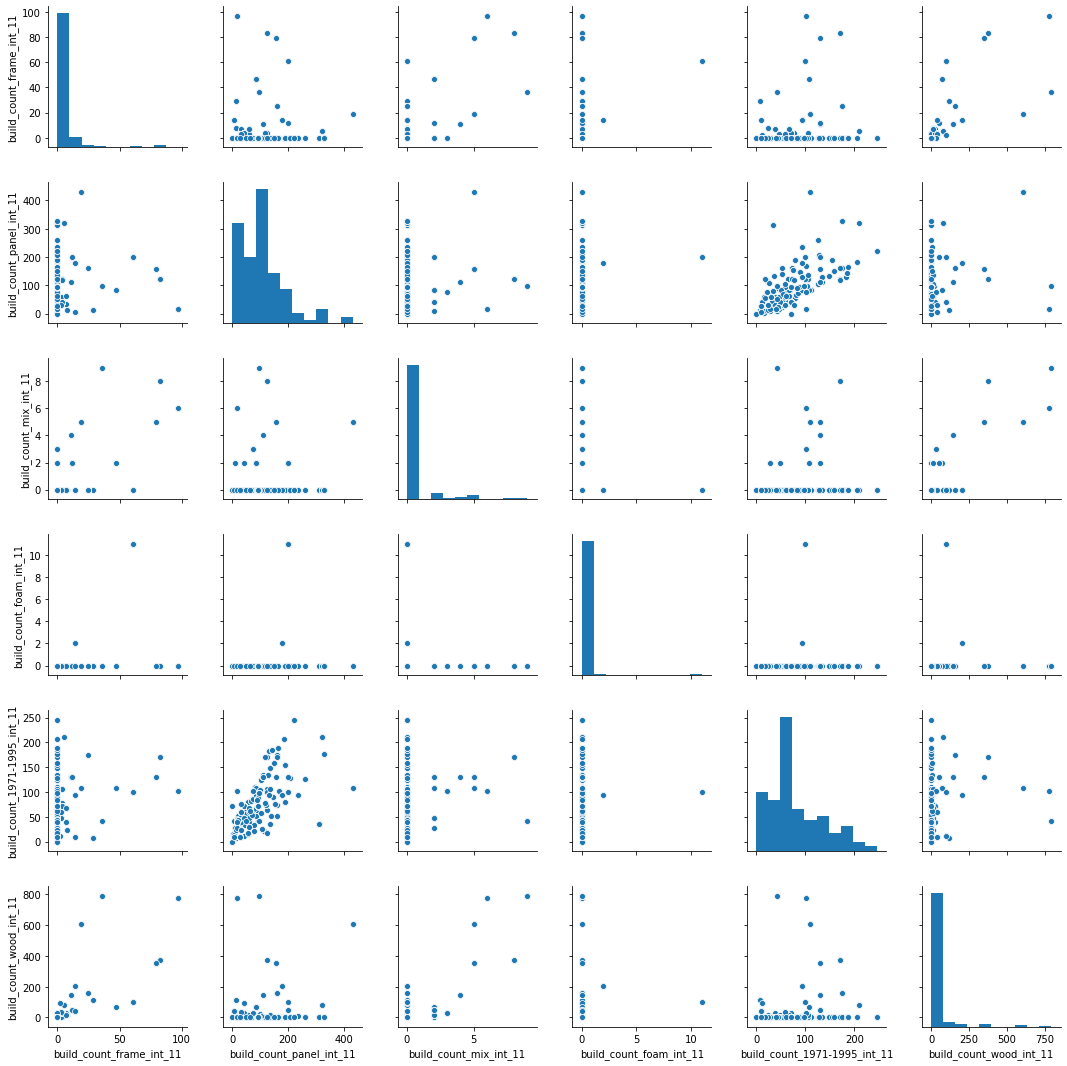

In [42]:
pkbu = list(pkbuild[pkbuild <0.02].index)
sns.pairplot(dfbuild[pkbu])

Not much can be said overall as there is hardly an overall trend for most of the features with a few exceptions. In the next file we will go more into detail and explore the data a bit more.